In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.chdir('..')
os.getcwd()

In [2]:
from src import *
import pandas as pd

In [12]:
root = '/home/yermaand/data/MultiDo/videa_prujezdy/*'

extensions = []
for path in sorted(glob(root)):

    file = get_file_name(path)
    extension = get_file_extension(path)

    extensions.append(extension)

    if extension in ['MOV', 'MP4', 'MTS', 'avi', 'mov', 'mp4', 'mts']:
        file = os.path.basename(path)
        target_path = f'data/video/{file}'

        if os.path.islink(target_path):
            os.unlink(target_path)
        os.symlink(path, target_path)

In [15]:
root = '/home/yermaand/data/MultiDo/videa_prujezdy/*'

for path in sorted(glob(root)):
    file = get_file_name(path)
    extension = get_file_extension(path)
    if extension == 'csv' and os.path.getsize(path) != 0:
        print(file)
        shutil.copy2(path, f'data/csv/{file}.csv')

01_A41
01_A6000
01_D600
01_RX100
01_Vypadova_A41
01_Vypadova_A6000
01_Vypadova_D600
02_A41
02_Cementarska_A41
02_Cementarska_D600
02_D600
02_RX100
03_KPrehradam_A6000
03_KPrehradam_D600
03_KPrehradam_Mobius
04_Komoranska_A41
04_Komoranska_A6000
04_Komoranska_Mobius
05_Mobius
05_RX100
05_iphone
06_Mobius
06_RX100
07_RX100
08_Mobius
08_iphone
09_Mobius
09_RX100
09_iphone
10_Mobius
10_RX100
10_iphone
11_Mobius
11_RX100
11_iphone
12_Mobius
12_RX100
12_iphone
13_Mobius
13_RX100
13_iphone
14_Mobius
14_RX100
15_Mobius
15_RX100
15_iphone
16_Mobius
16_RX100
16_iphone
17_Mobius
17_RX100
17_iphone
18_Prazska_Mobius
18_Prazska_RX100
18_Prazska_iphone
19_Krocehlavska_Mobius
19_Krocehlavska_RX100
19_Krocehlavska_iphone
20_Kovary_Mobius
20_Kovary_RX100
20_Kovary_iphone
21_Videnska_Mobius
21_Videnska_RX100
21_Videnska_iphone
22_Jesenicka_Mobius
22_Jesenicka_RX100
22_Jesenicka_iphone
23_KeZlatnikum_Mobius
23_KeZlatnikum_RX100
23_KeZlatnikum_iphone
24_Cernokostelecka_Mobius
24_Cernokostelecka_RX100
24_C

In [3]:
def optimize(views, events_start_time, events_end_time, energy_per_second, energy, is_rear=True, window_len=0.5):
    if is_rear:
        mask = views == 'rear'
        subset = events_start_time[mask] * energy_per_second
    else:
        mask = views != 'rear'
        subset = events_end_time[mask] * energy_per_second

    window_len = window_len * energy_per_second

    delta_best = None
    sum_of_energies_best = 0

    deltas = np.arange(0, 5.1, 0.1)

    for delta in deltas:
        delta = delta * energy_per_second

        if is_rear:
            window_from = subset - delta - window_len
        else:
            window_from = subset + delta - window_len
        window_from = np.clip(window_from, 0, len(energy)).astype(int)

        if is_rear:
            window_till = subset - delta + window_len
        else:
            window_till = subset + delta + window_len
        window_till = np.clip(window_till, 0, len(energy)).astype(int)

        sum_of_energies = 0

        for i, j in zip(window_from, window_till):
            sum_of_energies += energy[i: j].sum().item()

        if sum_of_energies > sum_of_energies_best:
            sum_of_energies_best = sum_of_energies
            # compensate for half of window length
            delta_best = delta + window_len / 2

    return delta_best / energy_per_second


In [4]:
files = load_files_from_dataset('002_eyedea_RX100')

In [81]:
file = files[0]

path = find_labels(file)

signal, sr = load_audio(file, return_sr=True)
signal_length = len(signal) // sr
csv = load_csv(file)
views = load_views_from_csv(csv)
events_start_time, events_end_time = load_event_time_from_csv(csv)

n_fft = 1024 * 1
hop_length = 512

stft = torch.stft(signal, n_fft=n_fft, hop_length=hop_length)
energy = stft[..., 0].pow(2).sum(0)

energy_per_second = len(energy) / signal_length

mask = views == 'rear'
if mask.sum() != 0:
    output_rear = optimize(views, events_start_time, events_end_time, energy_per_second, energy, is_rear=True)
    estimated_labels_1 = events_start_time[mask] - output_rear
else:
    output_rear = 0
    estimated_labels_1 = []

mask = views != 'rear'
if mask.sum() != 0:
    output_front = optimize(views, events_start_time, events_end_time, energy_per_second, energy, is_rear=False)
    estimated_labels_2 = events_end_time[mask] + output_front
else:
    output_front = 0
    estimated_labels_2 = []

print(output_rear, output_front)


1.35 1.1500000000000001


In [82]:
import torch.nn.functional as F

In [83]:
kernel = torch.ones(1, 1, 100) / 100
convolved_energy = F.conv1d(energy.reshape(1, 1, -1), kernel, padding='same').squeeze()
convolved_energy.shape

torch.Size([100862])

In [77]:
signal.shape

torch.Size([51641100])

In [78]:
convolved_energy.shape

torch.Size([403447])

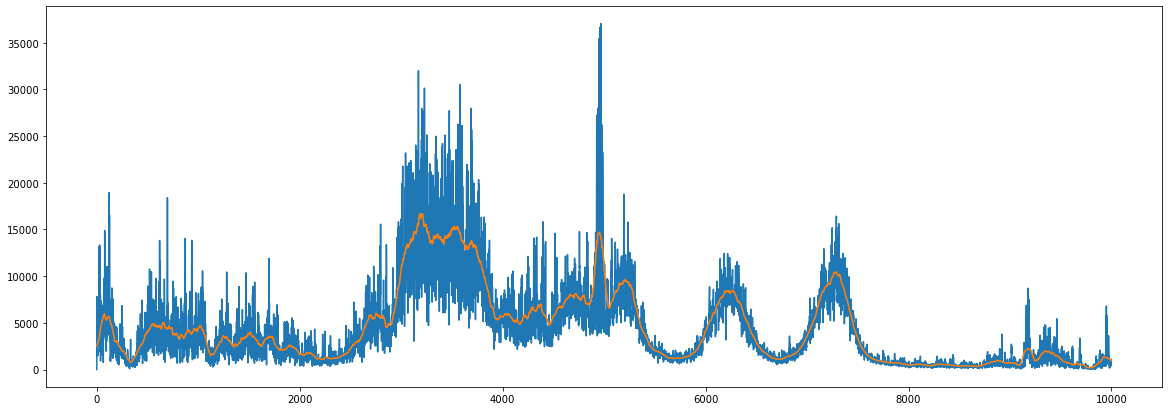

In [79]:
plt.figure(figsize=(20, 7))
plt.plot(energy[:10000])
plt.plot(convolved_energy[:10000])
# plt.plot(signal[:10000])

In [10]:
s1 = signal[:sr * 60]

In [13]:
energy.shape

torch.Size([403447])

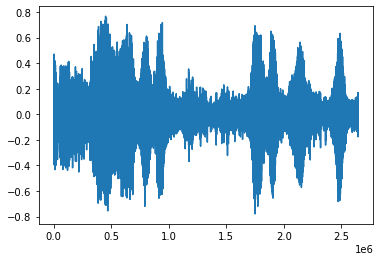

In [9]:
plt.plot(s1)

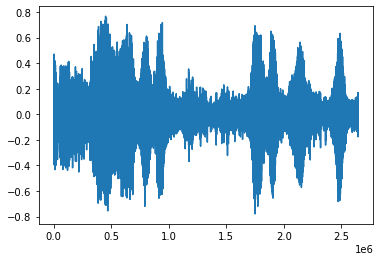

In [7]:
plt.plot(s1, rasterized=True)